Project 3

In [6]:
# !rm -rf Deep-Learning
# !git clone https://github.com/tmengel/Deep-Learning.git
# !ls Deep-Learning/project3/
# %cd Deep-Learning/project3
# !pwd


TRAIN = 10
VALIDATE = 10
# ntrain=86744, nval=10954

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

age_labels = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','more than 70']
gender_labels = ['Female','Male']
race_labels= ['East Asian', 'Indian', 'Black', 'White', 'Middle Eastern', 'Latino_Hispanic', 'Southeast Asian']
service_test_labels = ['True', 'False']
features = ['age','gender','race']
cat_labels = {
    'age': age_labels,
    'gender' : gender_labels,
    'race' : race_labels,
    # 'service_test' : service_test_labels
    }

# training_path = '/content/Deep-Learning/project3/fairface_label_train.csv'
# validation_path = '/content/Deep-Learning/project3/fairface_label_val.csv'
training_path = 'fairface_label_train.csv'
validation_path = 'fairface_label_val.csv'

def one_hot_encode(df,feature,labels):
    cats = df[feature].values
    one_hot = np.zeros((cats.size,labels.__len__()))
    for i in range(cats.size):
        one_hot[i][labels.index(cats[i])] = 1
    return one_hot

def one_hot_decode(one_hot,labels):
    return [labels[np.argmax(one_hot[i])] for i in range(one_hot.shape[0])]

def read_images(n, path):
    # read in csv file
    df = pd.read_csv(path)
    # sample n rows
    df = df.sample(n, random_state=42)
    # reset index
    df = df.reset_index(drop=True)
    # create empty list for images
    images = np.zeros((n, 32, 32, 1), dtype=np.uint8)
    # loop through each row and read in image file        
    for index, row in df.iterrows():
#         image_path = f'/content/Deep-Learning/project3/{row["file"]}'
        image_path = f'{row["file"]}'
        image = Image.open(image_path)
        img = np.array(image)
        img = img.reshape(32,32,1)
        images[index] = img

    df = df.drop(columns=["file"])
    df['image_id'] = df.index   
    return df, images

def plot_images(df,images):
    # plot images
    fig, axs = plt.subplots(len(images)//5, 5, figsize=(20, 20))
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(df.loc[i, "age"] + ", " + df.loc[i, "gender"] + ", " + df.loc[i, "race"])
    plt.show()
    
def min_max_scale_images(images):
    # Min-max scale each image
    images_min_max = np.zeros(images.shape)
    iter=0
    for i in images:
        ama = np.amax(i)
        ami = np.amin(i)
        i = (i - ami) / (ama - ami)
        images_min_max[iter] = i
        iter+=1
    return images_min_max

def count_categories(path):
    df = pd.read_csv(path)
    for column in df.columns:
        print(f"{column}: {df[column].nunique()} categories")

def load_data(n, path,plot=False):
    df, images = read_images(n, path)
    images = min_max_scale_images(images)
    if plot:
        plot_images(df,images)
    
    
    # One-hot encode labels
    one_hot = {}
    labels = {}
    for feature in features:
        one_hot[feature] = one_hot_encode(df, feature, cat_labels[feature])
        labels[feature] = one_hot_decode(one_hot[feature], cat_labels[feature])
    
    return images, one_hot, labels

def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # plot training and validation loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title('Model Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['train', 'val'], loc='best')

    plt.show()
    
def evaluate_model(model, images_test, one_hot_test, labels_test, target):
    # Evaluate the model on test data
    test_loss, test_acc = model.evaluate(images_test, one_hot_test[target])

    # Get predictions for the test data
    test_pred_one_hot = model.predict(images_test)
    test_pred_labels = one_hot_decode(test_pred_one_hot, cat_labels[target])

    # Create the confusion matrix
    cm = confusion_matrix(labels_test[target], test_pred_labels, labels=cat_labels[target])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=cat_labels[target], yticklabels=cat_labels[target])
    plt.xlabel('Predicted labels')
    ax = plt.gca()
    ax.invert_yaxis()
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()
    
    print('Final classification accuracy:', test_acc)
    
def plot_multi_history(history, features):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    # plot training and validation loss
    axs[0][0].plot(history.history[f'{features[0]}_output_loss'])
    axs[0][0].plot(history.history[f'val_{features[0]}_output_loss'])
    axs[0][0].set_title(f'{features[0]} Loss')
    axs[0][0].set_xlabel('Epoch')
    axs[0][0].set_ylabel('Loss')
    axs[0][0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[0][1].plot(history.history[f'{features[0]}_output_accuracy'])
    axs[0][1].plot(history.history[f'val_{features[0]}_output_accuracy'])
    axs[0][1].set_title(f'{features[0]} Accuracy')
    axs[0][1].set_xlabel('Epoch')
    axs[0][1].set_ylabel('Accuracy')
    axs[0][1].legend(['train', 'val'], loc='best')
    
    axs[1][0].plot(history.history[f'{features[1]}_output_loss'])
    axs[1][0].plot(history.history[f'val_{features[1]}_output_loss'])
    axs[1][0].set_title(f'{features[1]} Loss')
    axs[1][0].set_xlabel('Epoch')
    axs[1][0].set_ylabel('Loss')
    axs[1][0].legend(['train', 'val'], loc='best')

    # plot training and validation accuracy
    axs[1][1].plot(history.history[f'{features[1]}_output_accuracy'])
    axs[1][1].plot(history.history[f'val_{features[1]}_output_accuracy'])
    axs[1][1].set_title(f'{features[1]} Accuracy')
    axs[1][1].set_xlabel('Epoch')
    axs[1][1].set_ylabel('Accuracy')
    axs[1][1].legend(['train', 'val'], loc='best')
    

    plt.show()
    
def evaluate_multi_model(model, images_test, one_hot_test, labels_test, targets):
    evaluation = model.evaluate(images_test, [one_hot_test[targets[0]], one_hot_test[targets[1]]], verbose=0)
    print(f'Final classification accuracies: {targets[0]} {evaluation[3]}, {targets[1]} {evaluation[4]}')

    test_pred_one_hot_feature1, test_pred_one_hot_feature2  = model.predict(images_test)
    test_pred_labels_feature1 = one_hot_decode(test_pred_one_hot_feature1, cat_labels[targets[0]])
    test_pred_labels_feature2 = one_hot_decode(test_pred_one_hot_feature2, cat_labels[targets[1]])

    cm_feature1 = confusion_matrix(labels_test[targets[0]], test_pred_labels_feature1, labels=cat_labels[targets[0]])
    cm_feature2 = confusion_matrix(labels_test[targets[1]], test_pred_labels_feature2, labels=cat_labels[targets[1]])

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0] = sns.heatmap(cm_feature1, annot=True, cmap='viridis', fmt='g', xticklabels=cat_labels[targets[0]], yticklabels=cat_labels[targets[0]], ax=axs[0])
    axs[0].set_xlabel(f'Predicted {targets[0]} labels')
    axs[0].set_ylabel(f'True {targets[0]} labels')
    axs[0].set_title(f'{targets[0]} Confusion matrix')
    axs[0].invert_yaxis()
    axs[1] = sns.heatmap(cm_feature2, annot=True, cmap='viridis', fmt='g', xticklabels=cat_labels[targets[1]], yticklabels=cat_labels[targets[1]], ax=axs[1])
    axs[1].set_xlabel(f'Predicted {targets[1]} labels')
    axs[1].set_ylabel(f'True {targets[1]} labels')
    axs[1].set_title(f'{targets[1]} Confusion matrix')
    axs[1].invert_yaxis()

    # plt.title('Confusion matrices')
    plt.show()


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate, Dropout, Conv2DTranspose, Lambda, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def FullyConnectedNetwork(output_size):
    return Sequential([
            Flatten(input_shape=(32, 32, 1)),
            Dense(1024, activation='tanh'),
            Dense(512, activation='sigmoid'),
            Dense(100, activation='relu'),
            Dense(output_size, activation='softmax')
        ])
    
def SmallCNN(output_size):
    return Sequential([
            Conv2D(40,input_shape=(32,32,1),kernel_size=(5,5),strides=1,padding='valid', activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Flatten(),
            Dense(100,activation='relu'),
            Dense(output_size,activation='softmax')
        ])
    
def CustomCNN(output_size):
    return Sequential([
        Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(output_size,activation='softmax')
    ])

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    #Extract mean and log of variance
    z_mean, z_log_var = args
    #get batch size and length of vector (size of latent space)
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    #Return sampled number (need to raise var to correct power)
    return z_mean + K.exp(z_log_var) * epsilon

def VariationalAutoEncoder():
    latent_dim = 3
    intermediate_dim = 100
    ## Encoding
    inputs = Input(shape=(32,32,1),name='encoder_input')
    x0 = Conv2D(64, (3, 3), activation="relu", padding="same",name='encoder_conv1')(inputs)
    m0 = MaxPooling2D((2, 2))(x0)
    x1 = Conv2D(128, (3, 3), activation="relu", padding="same",name='encoder_conv2')(m0)
    m1 = MaxPooling2D((2, 2))(x1)
    f1 = Flatten()(m1)
    x = Dense(intermediate_dim, activation='relu', name="encoder_hidden_dense")(f1)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder_output')
#     encoder.summary()
    
#     ## Decoding
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x2 = Dense(intermediate_dim, activation='relu', name="decoder_hidden_dense")(latent_inputs)
    x3 = Dense(32*32, activation='relu', name="decoder_hidden_dense2")(x2)
    r2 = Reshape((32,32,1))(x3)
#     u2 = UpSampling2D((2,2))(r2)
    x4 = Conv2DTranspose(128, (3, 3), padding="same", name='decoder_conv1')(r2)
#     u4 = UpSampling2D((2,2))(x4)
    x5 = Conv2DTranspose(64, (3, 3), padding="same", name='decoder_conv2')(x4)
    outputs = Conv2DTranspose(1, (3, 3), padding="same", name='decoder_conv3')(x5)
    decoder = Model(latent_inputs,outputs,name='decoder_output')
#     decoder.summary()
    
    outputs = decoder(encoder(inputs)[2])
    
    return Model(inputs, outputs, name='vae')

def MultiTaskCNN(output_size, features):
    # Define inputs
    inputs = Input(shape=(32, 32, 1))

    # Convolutional layers for feature1 branch
    feature1_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',)(inputs)
    feature1_pool1 = MaxPooling2D(pool_size=(2, 2))(feature1_conv1)
    feature1_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(feature1_pool1)
    feature1_pool2 = MaxPooling2D(pool_size=(2, 2))(feature1_conv2)

    # Convolutional layers for feature2 branch
    feature2_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    feature2_pool1 = MaxPooling2D(pool_size=(2, 2))(feature2_conv1)
    feature2_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(feature2_pool1)
    feature2_pool2 = MaxPooling2D(pool_size=(2, 2))(feature2_conv2)

    # Flatten and concatenate branches
    feature1_flatten = Flatten()(feature1_pool2)
    feature2_flatten = Flatten()(feature2_pool2)
    merged = concatenate([feature1_flatten, feature2_flatten])

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(merged)
    feature1_dense2 = Dense(64, activation='relu')(dense1)
    feature1_output = Dense(output_size[0], activation='softmax', name=f'{features[0]}_output')(feature1_dense2)
    feature2_dense2 = Dense(64, activation='relu')(dense1)
    feature2_output = Dense(output_size[1], activation='softmax', name=f'{features[1]}_output')(feature2_dense2)

    return Model(inputs=inputs, outputs=[feature1_output, feature2_output])   

def do_task(target, model, ntrain, nval, loss, optimizer, epochs, batch_size, metrics):
    
    images_train, one_hot_train, labels_train = load_data(ntrain, training_path, plot=False)
    images_test, one_hot_test, labels_test = load_data(nval, validation_path, plot=False)
    
    # Create the model   
    output_size = len(cat_labels[target])
    if model == 'FullyConnectedNetwork':
        model = FullyConnectedNetwork(output_size)
    elif model == 'SmallCNN':
        model = SmallCNN(output_size)
    elif model == 'CustomCNN':
        model = CustomCNN(output_size)
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()
    
    # Train the model
    history = model.fit(images_train, one_hot_train[target], epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Plot the training and validation loss and accuracy
    plot_history(history)
    
    # Evaluate the model on test data
    evaluate_model(model, images_test, one_hot_test, labels_test, target) 

def do_multi_task(targets, model, ntrain, nval, loss, optimizer, epochs, batch_size, metrics):
    
    images_train, one_hot_train, labels_train = load_data(ntrain, training_path, plot=False)
    images_test, one_hot_test, labels_test = load_data(nval, validation_path, plot=False)

    # Create the model   
    output_size = [len(cat_labels[target]) for target in targets]
    model = MultiTaskCNN(output_size, targets)       
    model.compile(optimizer=optimizer,
                    loss = {f'{targets[0]}_output': loss, f'{targets[1]}_output': loss},
                    metrics=metrics)
    model.summary()

    # Train the model
    history = model.fit(images_train, {f'{targets[0]}_output': one_hot_train[targets[0]], f'{targets[1]}_output': one_hot_train[targets[1]]},
        epochs=epochs, batch_size=batch_size, validation_split=0.2)

    plot_multi_history(history, targets)

    evaluate_multi_model(model, images_test, one_hot_test, labels_test, targets) 
    
    
def do_VAE_task(ntrain,nval,loss,optimizer,epochs,batch_size,metrics):
    images_train, one_hot_train, labels_train = load_data(ntrain, training_path, plot=False)
    images_test, one_hot_test, labels_test = load_data(nval, validation_path, plot=False)
    
    model = VariationalAutoEncoder()
    model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    model.summary()

Preview Dataset

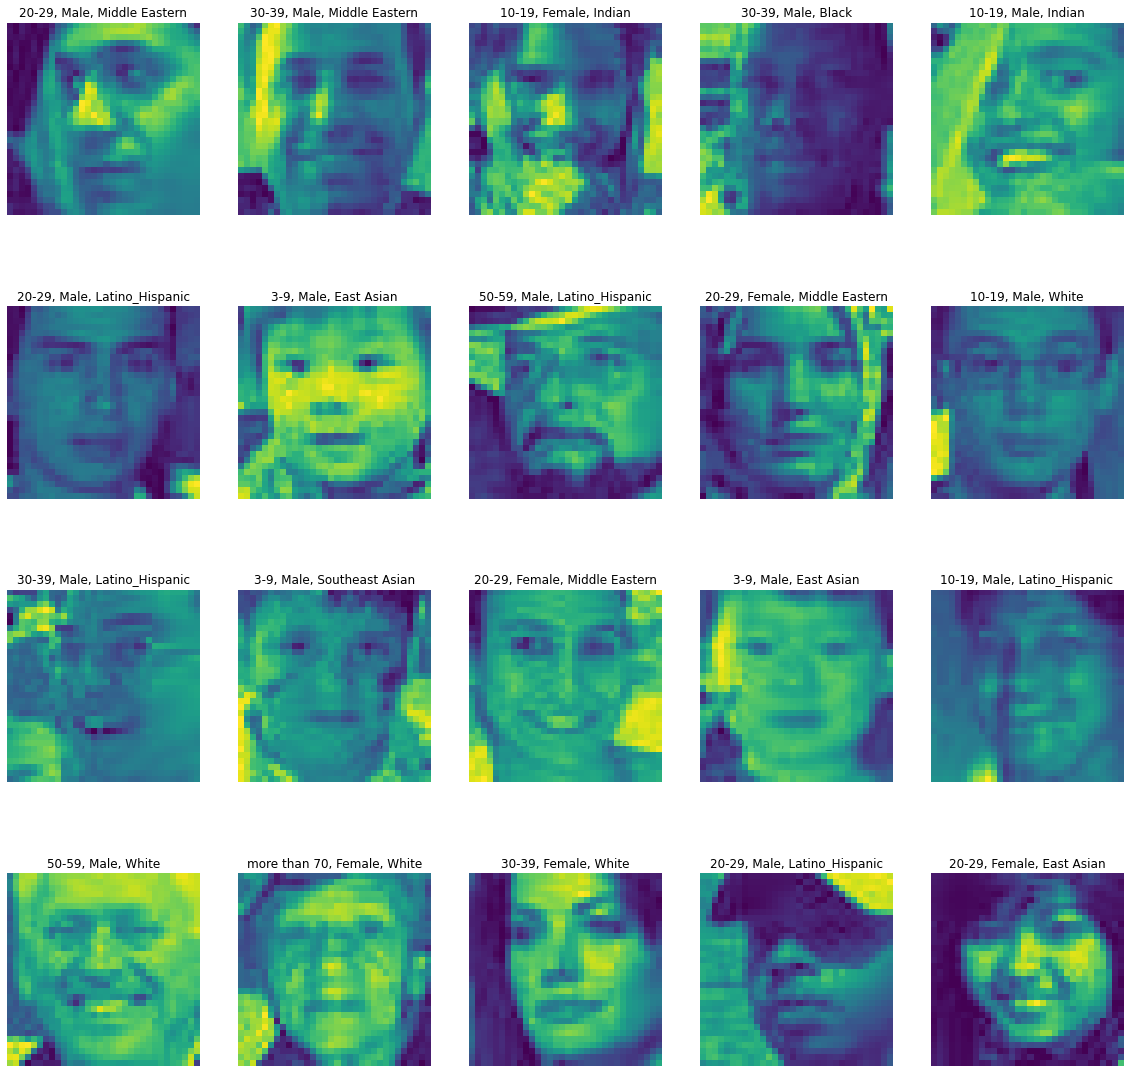

In [4]:
images_train, one_hot_train, labels_train = load_data(20, training_path, plot=True)

Task 1: Fully Connected Neural Network

2023-04-04 18:09:58.466150: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 18:09:58.612399: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
Total params: 1,626,609
Trainable params: 1,626,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 1s 644ms/step - loss: 2.4697 - accuracy: 0.0000e+00 - val_los

Epoch 52/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.0867 - val_accuracy: 0.5000
Epoch 53/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0836 - val_accuracy: 0.5000
Epoch 54/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0809 - val_accuracy: 0.5000
Epoch 55/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.0786 - val_accuracy: 0.5000
Epoch 56/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.0767 - val_accuracy: 0.5000
Epoch 57/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.0747 - val_accuracy: 0.5000
Epoch 58/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.0727 - val_accuracy: 0.5000
Epoch 59/100


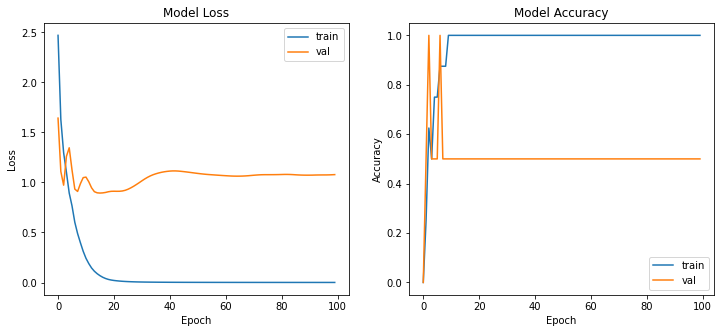

1/1 [==============================] - 0s 19ms/step - loss: 5.3273 - accuracy: 0.2000


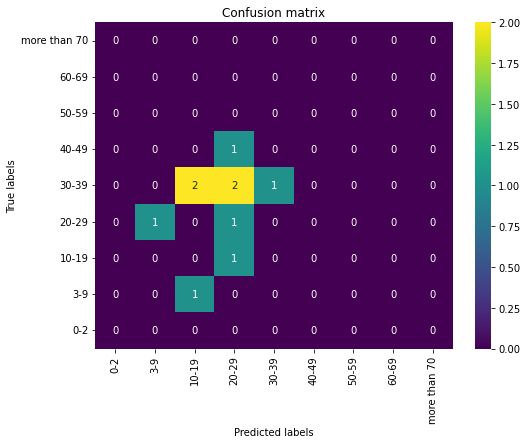

Final classification accuracy: 0.20000000298023224


In [7]:
do_task(target='age', model="FullyConnectedNetwork", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 202       
Total params: 1,625,902
Trainable params: 1,625,902
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 470ms/step - loss: 0.4336 - accuracy: 0.8750 - val_loss:

1/1 [==============================] - 0s 25ms/step - loss: 5.5160e-05 - accuracy: 1.0000 - val_loss: 5.8992 - val_accuracy: 0.5000
Epoch 52/100
1/1 [==============================] - 0s 24ms/step - loss: 5.2672e-05 - accuracy: 1.0000 - val_loss: 5.9243 - val_accuracy: 0.5000
Epoch 53/100
1/1 [==============================] - 0s 23ms/step - loss: 5.0362e-05 - accuracy: 1.0000 - val_loss: 5.9493 - val_accuracy: 0.5000
Epoch 54/100
1/1 [==============================] - 0s 27ms/step - loss: 4.8202e-05 - accuracy: 1.0000 - val_loss: 5.9741 - val_accuracy: 0.5000
Epoch 55/100
1/1 [==============================] - 0s 25ms/step - loss: 4.6191e-05 - accuracy: 1.0000 - val_loss: 5.9989 - val_accuracy: 0.5000
Epoch 56/100
1/1 [==============================] - 0s 24ms/step - loss: 4.4298e-05 - accuracy: 1.0000 - val_loss: 6.0234 - val_accuracy: 0.5000
Epoch 57/100
1/1 [==============================] - 0s 22ms/step - loss: 4.2555e-05 - accuracy: 1.0000 - val_loss: 6.0477 - val_accuracy: 0.500

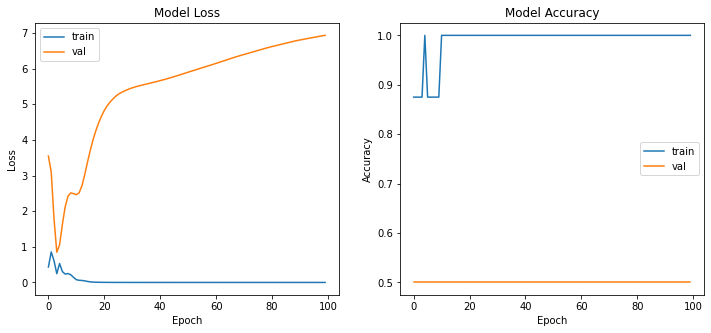

1/1 [==============================] - 0s 15ms/step - loss: 6.0298 - accuracy: 0.5000


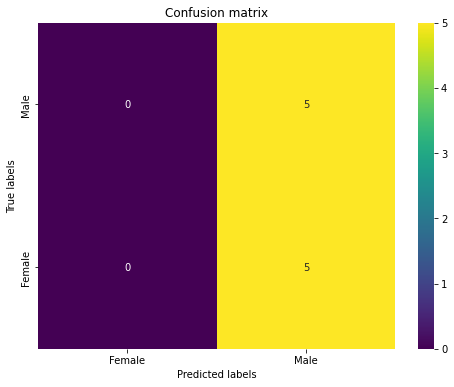

Final classification accuracy: 0.5


In [8]:
do_task(target='gender', model="FullyConnectedNetwork", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

Task 2: Small Convolutional Neural Network

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 40)        1040      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 40)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7840)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               784100    
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 909       
Total params: 786,049
Trainable params: 786,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 1s 587ms/step - loss: 2.1588 - accuracy: 0.3750 - val_loss: 1.5

1/1 [==============================] - 0s 20ms/step - loss: 1.5163e-04 - accuracy: 1.0000 - val_loss: 2.1498 - val_accuracy: 0.0000e+00
Epoch 51/100
1/1 [==============================] - 0s 21ms/step - loss: 1.4627e-04 - accuracy: 1.0000 - val_loss: 2.1534 - val_accuracy: 0.0000e+00
Epoch 52/100
1/1 [==============================] - 0s 20ms/step - loss: 1.4154e-04 - accuracy: 1.0000 - val_loss: 2.1570 - val_accuracy: 0.0000e+00
Epoch 53/100
1/1 [==============================] - 0s 20ms/step - loss: 1.3726e-04 - accuracy: 1.0000 - val_loss: 2.1606 - val_accuracy: 0.0000e+00
Epoch 54/100
1/1 [==============================] - 0s 21ms/step - loss: 1.3346e-04 - accuracy: 1.0000 - val_loss: 2.1643 - val_accuracy: 0.0000e+00
Epoch 55/100
1/1 [==============================] - 0s 22ms/step - loss: 1.3011e-04 - accuracy: 1.0000 - val_loss: 2.1681 - val_accuracy: 0.0000e+00
Epoch 56/100
1/1 [==============================] - 0s 21ms/step - loss: 1.2710e-04 - accuracy: 1.0000 - val_loss: 2.17

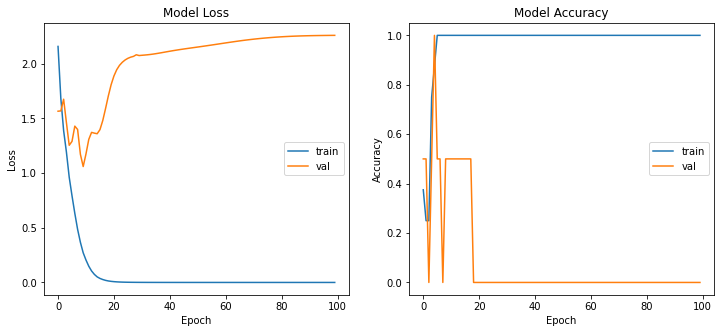

1/1 [==============================] - 0s 15ms/step - loss: 11.0352 - accuracy: 0.2000


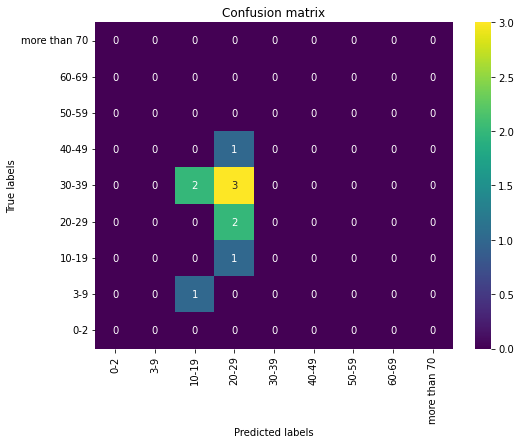

Final classification accuracy: 0.20000000298023224


In [9]:
do_task(target='age', model="SmallCNN", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 40)        1040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 40)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7840)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               784100    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 202       
Total params: 785,342
Trainable params: 785,342
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 417ms/step - loss: 0.6555 - accuracy: 0.7500 - val_loss: 1.5

Epoch 52/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0844 - accuracy: 1.0000 - val_loss: 5.4763 - val_accuracy: 0.5000
Epoch 53/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0842 - accuracy: 1.0000 - val_loss: 5.5470 - val_accuracy: 0.5000
Epoch 54/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0842 - accuracy: 1.0000 - val_loss: 5.5762 - val_accuracy: 0.5000
Epoch 55/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0840 - accuracy: 1.0000 - val_loss: 5.6199 - val_accuracy: 0.5000
Epoch 56/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0839 - accuracy: 1.0000 - val_loss: 5.6199 - val_accuracy: 0.5000
Epoch 57/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0838 - accuracy: 1.0000 - val_loss: 5.6357 - val_accuracy: 0.5000
Epoch 58/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0837 - accuracy: 1.0000 - val_loss: 5.6682 - val_accuracy: 0.5000
Epoch 59/100


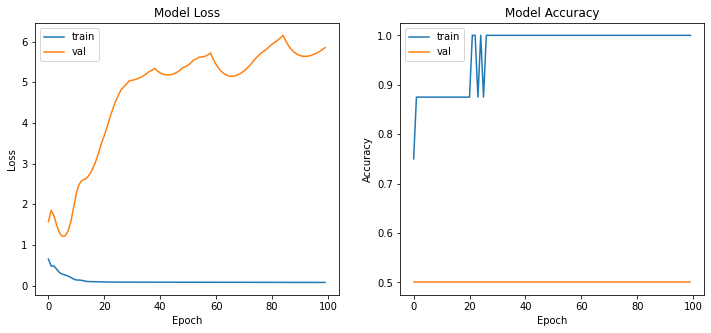

1/1 [==============================] - 0s 14ms/step - loss: 4.1481 - accuracy: 0.5000


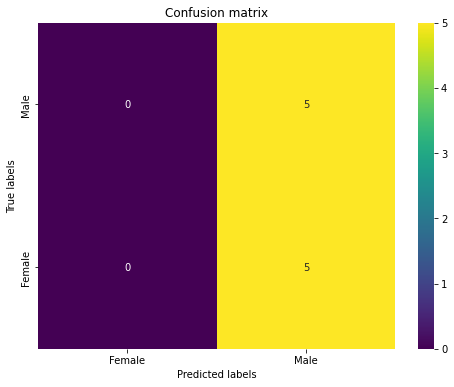

Final classification accuracy: 0.5


In [10]:
do_task(target='gender', model="SmallCNN", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

Task 3: Your own Convolutional Neural Network

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)             

1/1 [==============================] - 0s 49ms/step - loss: 9.9113e-04 - accuracy: 1.0000 - val_loss: 0.5707 - val_accuracy: 0.5000
Epoch 48/100
1/1 [==============================] - 0s 50ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.7368 - val_accuracy: 0.5000
Epoch 49/100
1/1 [==============================] - 0s 47ms/step - loss: 5.3444e-04 - accuracy: 1.0000 - val_loss: 0.9060 - val_accuracy: 0.5000
Epoch 50/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.0632 - val_accuracy: 0.5000
Epoch 51/100
1/1 [==============================] - 0s 51ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 1.1830 - val_accuracy: 0.5000
Epoch 52/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 1.2465 - val_accuracy: 0.5000
Epoch 53/100
1/1 [==============================] - 0s 51ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 1.2700 - val_accuracy: 0.5000
Epoch 54/100
1/1 [

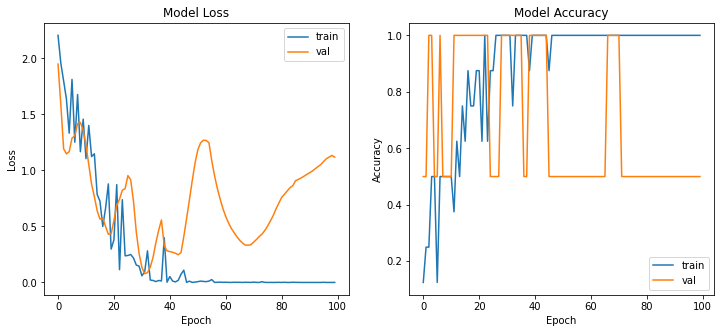

1/1 [==============================] - 0s 20ms/step - loss: 10.9136 - accuracy: 0.2000


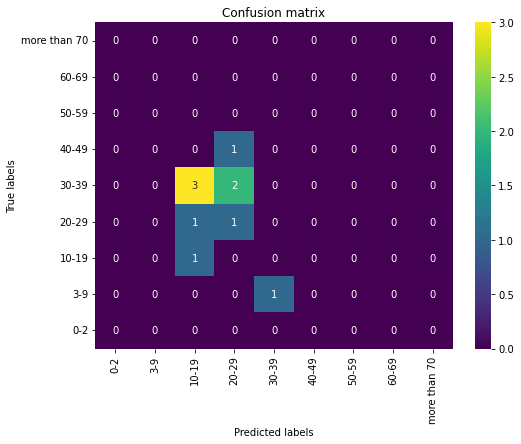

Final classification accuracy: 0.20000000298023224


In [11]:
do_task(target='age', model="CustomCNN", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)             

Epoch 47/100
1/1 [==============================] - 0s 49ms/step - loss: 2.9802e-08 - accuracy: 1.0000 - val_loss: 15.1879 - val_accuracy: 0.5000
Epoch 48/100
1/1 [==============================] - 0s 51ms/step - loss: 4.4703e-08 - accuracy: 1.0000 - val_loss: 15.7044 - val_accuracy: 0.5000
Epoch 49/100
1/1 [==============================] - 0s 46ms/step - loss: 8.9407e-08 - accuracy: 1.0000 - val_loss: 16.1886 - val_accuracy: 0.5000
Epoch 50/100
1/1 [==============================] - 0s 48ms/step - loss: 1.8402e-05 - accuracy: 1.0000 - val_loss: 16.6220 - val_accuracy: 0.5000
Epoch 51/100
1/1 [==============================] - 0s 49ms/step - loss: 8.1956e-07 - accuracy: 1.0000 - val_loss: 17.0241 - val_accuracy: 0.5000
Epoch 52/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 17.3969 - val_accuracy: 0.5000
Epoch 53/100
1/1 [==============================] - 0s 49ms/step - loss: 7.7037e-06 - accuracy: 1.0000 - val_loss: 17.7325 -

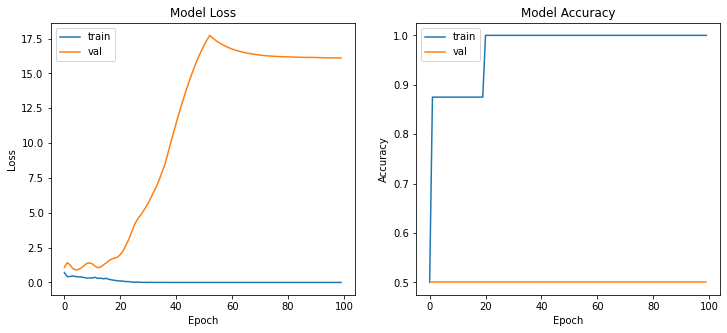

1/1 [==============================] - 0s 20ms/step - loss: 10.0620 - accuracy: 0.5000


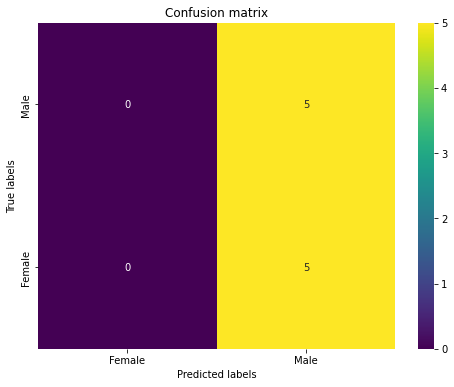

Final classification accuracy: 0.5


In [12]:
do_task(target='gender', model="CustomCNN", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

Task 4: Your own Convolutional Neural Network on both Tasks Simultaneously

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_8[0][0]                   
______________________________________________________________________________________________

1/1 [==============================] - 0s 46ms/step - loss: 0.4916 - age_output_loss: 0.2983 - gender_output_loss: 0.1932 - age_output_accuracy: 1.0000 - gender_output_accuracy: 0.8750 - val_loss: 2.2934 - val_age_output_loss: 0.7018 - val_gender_output_loss: 1.5915 - val_age_output_accuracy: 1.0000 - val_gender_output_accuracy: 0.5000
Epoch 14/100
1/1 [==============================] - 0s 45ms/step - loss: 0.3846 - age_output_loss: 0.2208 - gender_output_loss: 0.1639 - age_output_accuracy: 1.0000 - gender_output_accuracy: 0.8750 - val_loss: 2.7312 - val_age_output_loss: 0.9111 - val_gender_output_loss: 1.8201 - val_age_output_accuracy: 0.5000 - val_gender_output_accuracy: 0.5000
Epoch 15/100
1/1 [==============================] - 0s 49ms/step - loss: 0.2907 - age_output_loss: 0.1574 - gender_output_loss: 0.1334 - age_output_accuracy: 1.0000 - gender_output_accuracy: 0.8750 - val_loss: 2.6521 - val_age_output_loss: 0.8456 - val_gender_output_loss: 1.8065 - val_age_output_accuracy: 0.50

1/1 [==============================] - 0s 35ms/step - loss: 6.9598e-05 - age_output_loss: 3.3555e-05 - gender_output_loss: 3.6043e-05 - age_output_accuracy: 1.0000 - gender_output_accuracy: 1.0000 - val_loss: 9.4801 - val_age_output_loss: 1.2707 - val_gender_output_loss: 8.2095 - val_age_output_accuracy: 0.5000 - val_gender_output_accuracy: 0.5000
Epoch 37/100
1/1 [==============================] - 0s 35ms/step - loss: 5.2554e-05 - age_output_loss: 2.7789e-05 - gender_output_loss: 2.4764e-05 - age_output_accuracy: 1.0000 - gender_output_accuracy: 1.0000 - val_loss: 9.8138 - val_age_output_loss: 1.3342 - val_gender_output_loss: 8.4796 - val_age_output_accuracy: 0.5000 - val_gender_output_accuracy: 0.5000
Epoch 38/100
1/1 [==============================] - 0s 36ms/step - loss: 4.0932e-05 - age_output_loss: 2.3394e-05 - gender_output_loss: 1.7538e-05 - age_output_accuracy: 1.0000 - gender_output_accuracy: 1.0000 - val_loss: 10.1192 - val_age_output_loss: 1.3869 - val_gender_output_loss: 8

1/1 [==============================] - 0s 40ms/step - loss: 4.2766e-06 - age_output_loss: 2.9802e-06 - gender_output_loss: 1.2964e-06 - age_output_accuracy: 1.0000 - gender_output_accuracy: 1.0000 - val_loss: 12.4909 - val_age_output_loss: 1.4078 - val_gender_output_loss: 11.0831 - val_age_output_accuracy: 0.5000 - val_gender_output_accuracy: 0.5000
Epoch 59/100
1/1 [==============================] - 0s 51ms/step - loss: 4.0680e-06 - age_output_loss: 2.8163e-06 - gender_output_loss: 1.2517e-06 - age_output_accuracy: 1.0000 - gender_output_accuracy: 1.0000 - val_loss: 12.5131 - val_age_output_loss: 1.3932 - val_gender_output_loss: 11.1199 - val_age_output_accuracy: 0.5000 - val_gender_output_accuracy: 0.5000
Epoch 60/100
1/1 [==============================] - 0s 36ms/step - loss: 3.8594e-06 - age_output_loss: 2.6524e-06 - gender_output_loss: 1.2070e-06 - age_output_accuracy: 1.0000 - gender_output_accuracy: 1.0000 - val_loss: 12.5318 - val_age_output_loss: 1.3789 - val_gender_output_los

1/1 [==============================] - 0s 55ms/step - loss: 2.5779e-06 - age_output_loss: 1.6689e-06 - gender_output_loss: 9.0897e-07 - age_output_accuracy: 1.0000 - gender_output_accuracy: 1.0000 - val_loss: 12.5787 - val_age_output_loss: 1.1751 - val_gender_output_loss: 11.4037 - val_age_output_accuracy: 0.5000 - val_gender_output_accuracy: 0.5000
Epoch 81/100
1/1 [==============================] - 0s 39ms/step - loss: 2.5630e-06 - age_output_loss: 1.6540e-06 - gender_output_loss: 9.0897e-07 - age_output_accuracy: 1.0000 - gender_output_accuracy: 1.0000 - val_loss: 12.5750 - val_age_output_loss: 1.1686 - val_gender_output_loss: 11.4064 - val_age_output_accuracy: 0.5000 - val_gender_output_accuracy: 0.5000
Epoch 82/100
1/1 [==============================] - 0s 44ms/step - loss: 2.5183e-06 - age_output_loss: 1.6242e-06 - gender_output_loss: 8.9407e-07 - age_output_accuracy: 1.0000 - gender_output_accuracy: 1.0000 - val_loss: 12.5711 - val_age_output_loss: 1.1624 - val_gender_output_los

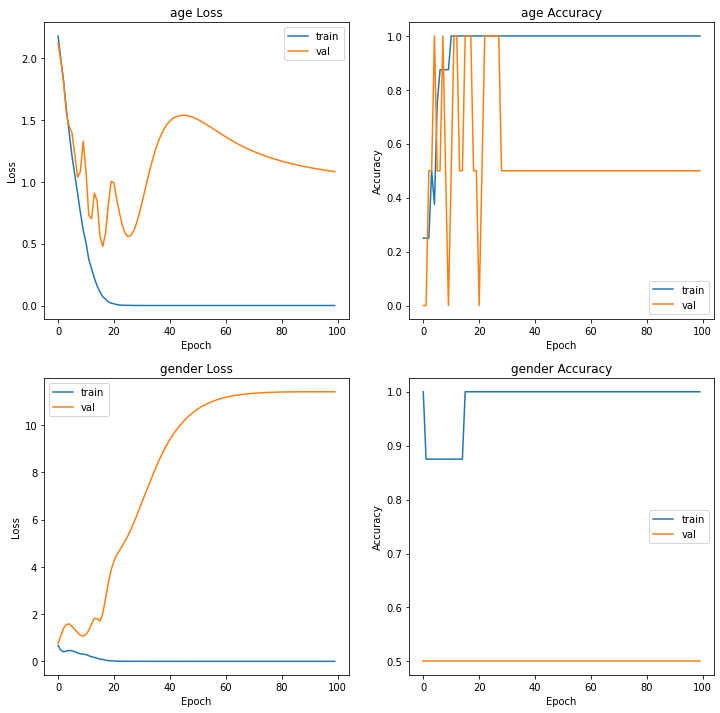

Final classification accuracies: age 0.20000000298023224, gender 0.4000000059604645


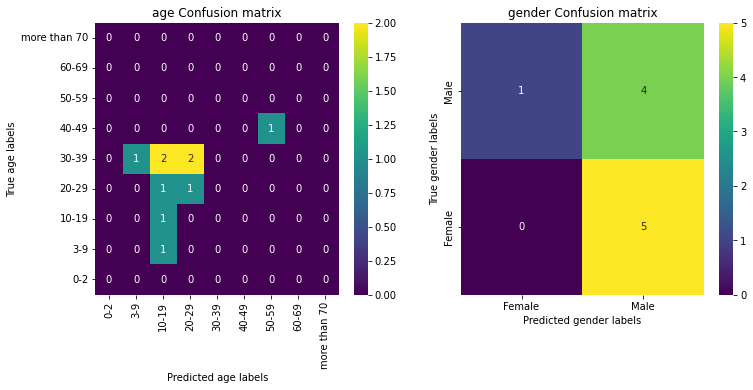

In [13]:
do_multi_task(targets=['age','gender'], model="MultiTaskCNN", ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=100, batch_size=32, metrics=['accuracy'])

In [14]:
do_VAE_task(ntrain=TRAIN, nval=VALIDATE, loss='categorical_crossentropy', optimizer='adam', epochs=10, batch_size=32, metrics=['accuracy'])

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder_output (Functional)  [(None, 3), (None, 3), (N 894402    
_________________________________________________________________
decoder_output (Functional)  (None, 32, 32, 1)         179473    
Total params: 1,073,875
Trainable params: 1,073,875
Non-trainable params: 0
_________________________________________________________________


In [15]:
# !git config --global user.email "tmengel@vols.utk.edu"
# !git config --global user.name "tmengel"
# !git status
# !git add Project3.ipynb
# !git commit -m "Added output from google collab"
# !git push